In [1]:
import torch
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rate = 4/7
EsdB_list = torch.arange(-2, 10, 0.5)
# EsdB_list = torch.tensor([10])

snr_list = 10.0**(EsdB_list/10.0)
EbNo_list = snr_list/rate/2
EbNodB_list = 10*np.log10(EbNo_list)

In [4]:
def i2b(integer, length=4):
    return torch.tensor(list(map(lambda x : [int(z) for z in format(x, '0{}b'.format(length))], integer)))

def encode(U, G):
    return torch.fmod(torch.mm(U, G), 2).to(device)

def mod_bpsk(C):
    X = -(2.0*C-1.0)
    return X

def awgn(X, SNR):
    Z = (torch.randn((X.shape[0], X.shape[1]))/np.sqrt(SNR)).to(device)
    Y = X + Z
    return Y

def decode_ml(Y, CB):
    indx = torch.argmin((torch.abs(Y.unsqueeze(1) - CB)**2).sum(axis=2), dim=1)
    U_hat = CB[indx]
    return U_hat

def decode_hard(Y):
    Y = (Y > 0).type(torch.float)
    Y[Y == 0] = -1.0
    return Y

In [5]:
G = torch.tensor([[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0],
                  [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0],
                  [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0],
                  [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]])

H = torch.tensor([[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0],
                  [1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0],
                  [0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0]])

i = torch.arange(0,16)
I = i2b(i, 4).type(torch.float)
CB = mod_bpsk(encode(I, G))


In [6]:
I, CB = I.to(device), CB.to(device)
G, H = G.to(device), H.to(device)



In [7]:
u = torch.randint(0, 16, (1000000,))
U = i2b(u).type(torch.float)
U = U.to(device)

In [8]:
U.shape

torch.Size([1000000, 4])

In [9]:
def atanh(x, eps):   
    clamp = 1-eps
    return torch.atanh(torch.clamp(x, min=-clamp, max=clamp))


In [10]:
class Sum_p():
    def __init__(self, Parity_check_matrix, U, SNR):
        self.U = U
        self.pcm = Parity_check_matrix
        self.num_F = Parity_check_matrix.shape[0]
        self.num_X = Parity_check_matrix.shape[1]
        self.Xlist = [Node_X(self.pcm[:,i], self.U[:,i], SNR, i) for i in range(self.num_X)]
        self.Flist = [Node_func(self.pcm[i], self.U) for i in range(self.num_F)]

       
    def Iter(self, num):
        # init
        f2x = torch.zeros(self.num_F, self.num_X, self.U.shape[0], 1).to(device)
        x2f = torch.zeros((self.num_X, self.num_F, self.U.shape[0], 1)).to(device)
        U_hat = torch.empty((self.U.shape[0], self.num_X)).to(device)
            
        # 업데이트
        for i in range(num):
            for n, x in enumerate(self.Xlist):
                x2f[n] = x.update_x2f(f2x[:, n, :], i)
            for n, f in enumerate(self.Flist):
                f2x[n] = f.update_f2x(x2f[:, n, :])

        # U_hat
        for n, x in enumerate(self.Xlist):
            U_hat[:, n] = x.est_U(f2x[:, n, :])
            
        return U_hat
    
    
##############
# Node_func:
#
##############

class Node_func():
    def __init__(self, vec, U):
        self.X_index = torch.where(vec == 1)[0]
        self.f2x = torch.zeros((vec.shape[0], U.shape[0], 1)).to(device)
    
    def update_f2x(self, X):
        x2f = torch.tanh(((X[self.X_index])/2))
        x2f = 2*atanh(x2f.prod(dim=0)/x2f, 1e-4)

        self.f2x[self.X_index] = x2f
        return self.f2x
        

##############
# Node_X:
#
##############

class Node_X():
    def __init__(self, pcm, U, SNR, i):
        self.i = i
        self.F_index = torch.where(pcm == 1)[0]
        self.F_num = self.F_index.shape[0]
        self.xi = torch.tensor([1, -1]).to(device) 
        self.p = self.get_p(U, SNR).to(device)
        self.x2f = torch.zeros(pcm.shape[0], self.p.shape[0], 1).to(device)
    
    def get_p(self, U, SNR):
        u = U.reshape(-1, 1)
        p = torch.exp(-1*((torch.abs(u-self.xi)**2)/2)*SNR)
        p = torch.log(p[:, 0]/p[:, 1]).reshape(-1, 1)
        return p
    
    def update_x2f(self, F, i):
        f = F[self.F_index]
        f = (f.sum(dim=0).unsqueeze(0)-f) + self.p
        self.x2f[self.F_index] = f
        return self.x2f
    
    def est_U(self, F):
        f = F[self.F_index]
        f = (f.sum(dim=0).unsqueeze(0))
        tf = (f < 0).squeeze()
        out = torch.ones(tf.shape[0])
        out[tf] = -1
        return out

In [11]:
db = []
ber = []

for SNR in tqdm(snr_list):
    print('\nSNR :', SNR)
    C = encode(U, G).to(device)
    X = mod_bpsk(C).to(device)    
    Y = awgn(X, SNR).to(device)
    Sum = Sum_p(H, Y, SNR)
    
    U_hat = Sum.Iter(10)
    er = (X != U_hat).sum()/(U_hat.shape[0]*U_hat.shape[1])
    ber.append(er.detach().cpu().numpy())


  0%|          | 0/24 [00:00<?, ?it/s]


SNR : tensor(0.6310)

SNR : tensor(0.7079)

SNR : tensor(0.7943)

SNR : tensor(0.8913)

SNR : tensor(1.)

SNR : tensor(1.1220)

SNR : tensor(1.2589)

SNR : tensor(1.4125)

SNR : tensor(1.5849)

SNR : tensor(1.7783)

SNR : tensor(1.9953)

SNR : tensor(2.2387)

SNR : tensor(2.5119)

SNR : tensor(2.8184)

SNR : tensor(3.1623)

SNR : tensor(3.5481)

SNR : tensor(3.9811)

SNR : tensor(4.4668)

SNR : tensor(5.0119)

SNR : tensor(5.6234)

SNR : tensor(6.3096)

SNR : tensor(7.0795)

SNR : tensor(7.9433)

SNR : tensor(8.9125)


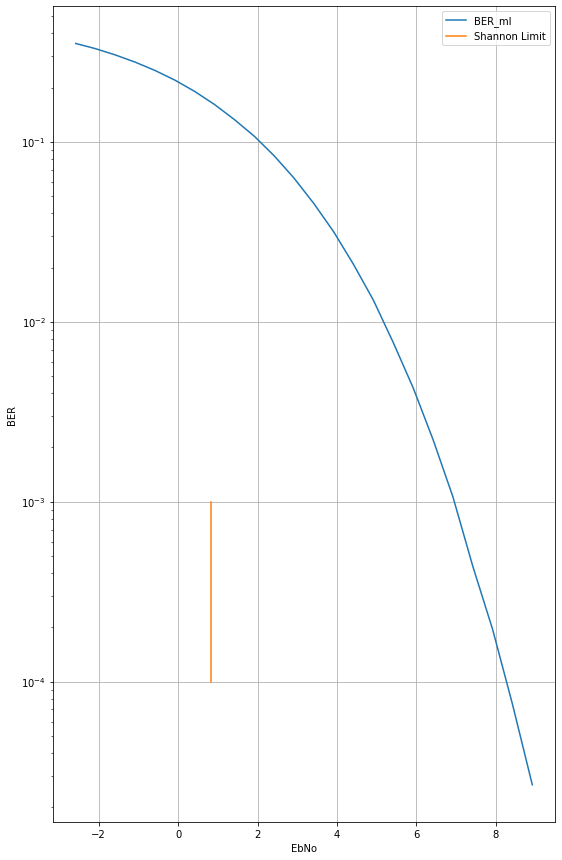

In [12]:
shannon_lim = 10.0*np.log10(2.0**(2*rate)-1)
norm_shannon_lim = 10.0*np.log10((2.0**(2*rate)-1)*rate/2)

plt.figure(figsize=(9,15))
plt.semilogy(EbNodB_list, ber)
plt.semilogy([shannon_lim, shannon_lim], [1e-4,1e-3])
plt.legend(['BER_ml','Shannon Limit'])
plt.xlabel('EbNo')
plt.ylabel('BER')
plt.grid()
plt.savefig('output.png')